# Benchmarking Partitioned Delta Lake Tables for Performance

In [ ]:
"""
Create a SparkSession object with various configurations
spark = SparkSession.builder \
    .appName("MyApp03")  \                                                                           # Set the application name for the Spark session
    .master("spark://192.168.0.144:7077") \                                                          # Specify the master URL for the Spark cluster
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \                     # Add Delta Lake extension for Spark SQL
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \  # Set the catalog implementation to Delta
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \                     # Set the URI for the Hive metastore
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \  # Set the JDBC URL for the Hive metastore
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \      # Set the JDBC driver class name
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \                              # Set the username for the JDBC connection
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \  # Set the password for the JDBC connection using an environment variable
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2,io.delta:delta-spark_2.12:3.1.0") \  # Include necessary packages for Kafka and Delta Lake
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \       # Set the log store class for Delta Lake
    .config("spark.executor.memory", "10g") \                                                        # Set the memory allocated to each executor
    .config("spark.executor.cores", "3") \                                                           # Set the number of cores allocated to each executor
    .config("spark.driver.memory", "20g") \                                                          # Set the memory allocated to the driver
    .config("spark.sql.adaptive.enabled", "true") \                                                  # Enable adaptive query execution
    .config("spark.sql.shuffle.partitions", "1000") \                                                # Set the number of partitions for shuffling
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \                              # Set the default file system to HDFS
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \          # Enable clustering table preview for Delta tables
    .enableHiveSupport() \                                                                           # Enable support for Hive
    .getOrCreate()                                                                                   # Create the SparkSession object
"""

In [93]:
spark.stop()

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("Compaction") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .enableHiveSupport() \
    .getOrCreate()

24/08/04 09:56:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
import os

# Set Hadoop environment variables
os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

# Verify that the environment variables are set
!echo $HADOOP_HOME
!echo $PATH


/usr/local/hadoop
/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/local/hadoop/bin


In [7]:
# Commands to delete directories if needed
#!hdfs dfs -du -s -h /datalake/partition/partition_yearday
#!hdfs dfs -du -s -h /datalake/partition/partition_yearday_medium
#!hdfs dfs -du -s -h /datalake/partition/partition_yearday_large
#!hdfs dfs -du -s -h /datalake/partition/partition_nopart
#!hdfs dfs -du -s -h /datalake/partition/partition_nopart_medium
#!hdfs dfs -du -s -h /datalake/partition/partition_nopart_large  

In [42]:
#spark.sql("DROP DATABASE IF EXISTS partition CASCADE")
#spark.sql("CREATE DATABASE IF NOT EXISTS partition LOCATION 'hdfs://192.168.0.144:9000/datalake/partition'")
spark.sql("USE partition")

DataFrame[]

In [43]:
spark.sql("show tables").orderBy("tableName").show(truncate=False)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [44]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
from pyspark.sql.functions import col

spark.sql("USE partition")

# Parameters
num_pairs = 3  # Number of table pairs to create
max_rows =  8 # Maximum number of rows for the largest table 1000000000 - 10 billion records

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]

# Drop and create tables
for i in range(num_pairs):
    part_table_name_good = f"partition_yearsensor_{row_counts[i]}"
    part_table_name_bad = f"partition_yearcountry_{row_counts[i]}"
    nopart_table_name = f"partition_nopart_{row_counts[i]}"
    
    spark.sql(f"DROP TABLE IF EXISTS {part_table_name_good}")
    spark.sql(f"DROP TABLE IF EXISTS {part_table_name_bad}")
    spark.sql(f"DROP TABLE IF EXISTS {nopart_table_name}")
    
    spark.sql(f"""
    CREATE TABLE {part_table_name_good} (
        date DATE,
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        sensor_id STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG
    )
    USING delta
    PARTITIONED BY (year, sensor_id)
    """)
    
    spark.sql(f"""
    CREATE TABLE {part_table_name_bad} (
        date DATE,
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        sensor_id STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG
    )
    USING delta
    PARTITIONED BY (year, country)
    """)
    
    spark.sql(f"""
    CREATE TABLE {nopart_table_name} (
        date DATE,
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        sensor_id STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG
    )
    USING delta
    """)

countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", 
    "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", 
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", 
    "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia", 
    "Comoros", "Congo", "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", "Dominica", 
    "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", 
    "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", 
    "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", 
    "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", 
    "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", 
    "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", 
    "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", 
    "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea", 
    "North Macedonia", "Norway", "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", 
    "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", 
    "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", 
    "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", 
    "Somalia", "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", 
    "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago"
]

sensor_ids = [
    "MVRYBT70",
    "X8LEFMOY",
    "G8D1L8BF",
    "AE5SXNCD",
    "Q7CX93NT",
    "XIAEJRCC",
    "HZ09P4NP",
    "KXVAB2N1",
    "9OAF5ZAS",
    "EM1Y2913"
]

def generate_data(timestamp, nrows):
    date = timestamp.date()
    return spark.range(nrows*1000000000).select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        element_at(array([lit(sensor_id) for sensor_id in sensor_ids]), (rand() * len(sensor_ids)).cast("int") + 1).alias("sensor_id"),
        (col("id") + 1).alias("event_id"),
        ((col("id") + 1000) + 1).alias("actor_id"),
        year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day")
    )

for i, rows in enumerate(row_counts):
    timestamp = datetime(2024, 1, 1) + timedelta(hours=i)
    
    part_table_name_good = f"partition_yearsensor_{row_counts[i]}"
    part_table_name_bad = f"partition_yearcountry_{row_counts[i]}"
    nopart_table_name = f"partition_nopart_{row_counts[i]}"
    
    insert_data = generate_data(timestamp, rows)
    insert_data.write.format("delta").mode("append").saveAsTable(part_table_name_good)
    insert_data.write.format("delta").mode("append").saveAsTable(part_table_name_bad)
    insert_data.write.format("delta").mode("append").saveAsTable(nopart_table_name)

24/08/02 15:14:31 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`partition`.`partition_yearsensor_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/02 15:14:31 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/08/02 15:14:31 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`partition`.`partition_yearcountry_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/02 15:14:32 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`partition`.`partition_nopart_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with 

In [45]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_2",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_2",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_2"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()




Optimizing and compacting table: partition_yearsensor_8


CPU times: user 985 ms, sys: 580 ms, total: 1.56 s
Wall time: 1h 5min 9s
Optimizing and compacting table: partition_yearcountry_8


CPU times: user 3.21 s, sys: 1.86 s, total: 5.07 s
Wall time: 1h 9min 35s
Optimizing and compacting table: partition_nopart_8


CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 1.52 s
Optimizing and compacting table: partition_yearsensor_4


CPU times: user 858 ms, sys: 523 ms, total: 1.38 s
Wall time: 52min 40s
Optimizing and compacting table: partition_yearcountry_4


CPU times: user 2.76 s, sys: 1.7 s, total: 4.46 s
Wall time: 1h 1min 25s
Optimizing and compacting table: partition_nopart_4
CPU times: user 657 µs, sys: 408 µs, total: 1.07 ms
Wall time: 1.13 s
Optimizing and compacting table: partition_yearsensor_2


CPU times: user 375 ms, sys: 308 ms, total: 683 ms
Wall time: 27min 3s
Optimizing and compacting table: partition_yearcountry_2


CPU times: user 1.31 s, sys: 933 ms, total: 2.25 s
Wall time: 29min 52s
Optimizing and compacting table: partition_nopart_2
CPU times: user 774 µs, sys: 489 µs, total: 1.26 ms
Wall time: 1.03 s


In [49]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_8",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_4",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_2",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_2",
    "hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_2"
]


def vacuum_delta_table(table_path):
    spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
    delta_table_obj = DeltaTable.forPath(spark, table_path)
    delta_table_obj.vacuum(0)

for path in table_paths:
    table_name = path.split("/")[-1]
    print(f"Vaccuum table: {table_name}")
    %time vacuum_delta_table(path)

Vaccuum table: partition_yearsensor_8


Deleted 280 files and directories in a total of 287 directories.
CPU times: user 25.3 ms, sys: 108 ms, total: 133 ms
Wall time: 26.7 s
Vaccuum table: partition_yearcountry_8


Deleted 4928 files and directories in a total of 4603 directories.
CPU times: user 54.3 ms, sys: 75.2 ms, total: 129 ms
Wall time: 32.3 s
Vaccuum table: partition_nopart_8


Deleted 0 files and directories in a total of 1 directories.
CPU times: user 35.8 ms, sys: 79.2 ms, total: 115 ms
Wall time: 16.3 s
Vaccuum table: partition_yearsensor_4


Deleted 260 files and directories in a total of 144 directories.
CPU times: user 28.5 ms, sys: 68.3 ms, total: 96.8 ms
Wall time: 16.4 s
Vaccuum table: partition_yearcountry_4


Deleted 4576 files and directories in a total of 2302 directories.
CPU times: user 19.4 ms, sys: 116 ms, total: 136 ms
Wall time: 35.6 s
Vaccuum table: partition_nopart_4


Deleted 0 files and directories in a total of 1 directories.
CPU times: user 24.2 ms, sys: 92.1 ms, total: 116 ms
Wall time: 14.6 s
Vaccuum table: partition_yearsensor_2


Deleted 200 files and directories in a total of 78 directories.
CPU times: user 9.91 ms, sys: 140 ms, total: 150 ms
Wall time: 15.8 s
Vaccuum table: partition_yearcountry_2


Deleted 3520 files and directories in a total of 1240 directories.
CPU times: user 42.3 ms, sys: 96.5 ms, total: 139 ms
Wall time: 32.4 s
Vaccuum table: partition_nopart_2


Deleted 0 files and directories in a total of 1 directories.
CPU times: user 11.1 ms, sys: 121 ms, total: 132 ms
Wall time: 15.5 s


In [ ]:
from pyspark.sql.functions import lit, col
import time

# Function to generate data for updating existing records
def generate_update_data(timestamp, nrows):
    date = timestamp.date()
    return spark.range(nrows).select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        (rand() * 100).alias("value"),  # updated values
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        element_at(array([lit(sensor_id) for sensor_id in sensor_ids]), (rand() * len(sensor_ids)).cast("int") + 1).alias("sensor_id"),
        (col("id") + 1).alias("event_id"),
        ((col("id") + 1000) + 1).alias("actor_id"),
        year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day")
    )

# Define number of rows to update and the update timestamp
update_rows = 100  # Number of rows to update
update_timestamp = datetime(2024, 1, 1, 12)  # Update timestamp

for i, rows in enumerate(row_counts):
    part_table_name_good = f"partition_yearsensor_{row_counts[i]}"
    part_table_name_bad = f"partition_yearcountry_{row_counts[i]}"
    nopart_table_name = f"partition_nopart_{row_counts[i]}"
    
    update_data = generate_update_data(update_timestamp, update_rows)
    
    start_time = time.time()
    part_table_good_temp_view = "part_table_good_temp_view"
    update_data.createOrReplaceTempView(part_table_good_temp_view)
    spark.sql(f"""
    MERGE INTO {part_table_name_good} AS target
    USING {part_table_good_temp_view} AS source
    ON target.event_id = source.event_id
    WHEN MATCHED THEN
      UPDATE SET *
    """)
    end_time = time.time()
    print(f"Time taken to update {part_table_name_good}: {end_time - start_time} seconds")
    
    start_time = time.time()
    part_table_bad_temp_view = "part_table_bad_temp_view"
    update_data.createOrReplaceTempView(part_table_bad_temp_view)
    spark.sql(f"""
    MERGE INTO {part_table_name_bad} AS target
    USING {part_table_bad_temp_view} AS source
    ON target.event_id = source.event_id
    WHEN MATCHED THEN
      UPDATE SET *
    """)
    end_time = time.time()
    print(f"Time taken to update {part_table_name_bad}: {end_time - start_time} seconds")
    
    start_time = time.time()
    nopart_table_temp_view = "nopart_table_temp_view"
    update_data.createOrReplaceTempView(nopart_table_temp_view)
    spark.sql(f"""
    MERGE INTO {nopart_table_name} AS target
    USING {nopart_table_temp_view} AS source
    ON target.event_id = source.event_id
    WHEN MATCHED THEN
      UPDATE SET *
    """)
    end_time = time.time()
    print(f"Time taken to update {nopart_table_name}: {end_time - start_time} seconds")


In [ ]:
# Function to generate data for adding new records
def generate_new_data(timestamp, nrows):
    date = timestamp.date()
    return spark.range(nrows).select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        element_at(array([lit(sensor_id) for sensor_id in sensor_ids]), (rand() * len(sensor_ids)).cast("int") + 1).alias("sensor_id"),
        (col("id") + 1000000).alias("event_id"),  
        ((col("id") + 2000000) + 1).alias("actor_id"), 
        year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day")
    )

# Define number of rows to add and the new data timestamp
add_rows = 1000  
new_data_timestamp = datetime(2024, 1, 2)  

for i, rows in enumerate(row_counts):
    part_table_name_good = f"partition_yearsensor_{row_counts[i]}"
    part_table_name_bad = f"partition_yearcountry_{row_counts[i]}"
    nopart_table_name = f"partition_nopart_{row_counts[i]}"
    
    new_data = generate_new_data(new_data_timestamp, add_rows)
    
    start_time = time.time()
    new_data.write.format("delta").mode("append").saveAsTable(part_table_name_good)
    end_time = time.time()
    print(f"Time taken to add new data to {part_table_name_good}: {end_time - start_time} seconds")
    
    start_time = time.time()
    new_data.write.format("delta").mode("append").saveAsTable(part_table_name_bad)
    end_time = time.time()
    print(f"Time taken to add new data to {part_table_name_bad}: {end_time - start_time} seconds")
    
    start_time = time.time()
    new_data.write.format("delta").mode("append").saveAsTable(nopart_table_name)
    end_time = time.time()
    print(f"Time taken to add new data to {nopart_table_name}: {end_time - start_time} seconds")


In [4]:
tables_df = spark.sql("SHOW TABLES")
tables = tables_df.collect()

def print_example_rows(table_name):
    print(f"First five rows from table {table_name}:")
    spark.sql(f"SELECT * FROM {table_name} LIMIT 300").show(truncate=False)

for row in tables:
    if not row['isTemporary']:
        table_name = row['tableName']
        print_example_rows(table_name)

First five rows from table partition_nopart_10000000000:


+----------+---------------------+-------------------+--------------------------------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country                         |sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+--------------------------------+---------+---------+---------+----+------+--------+
|2024-01-01|2026-02-10 14:31:06.6|0.3775346099006023 |Armenia                         |G8D1L8BF |666666667|666667667|2026|202602|20260210|
|2024-01-01|2026-02-10 14:31:06.7|0.6888203085404002 |Taiwan                          |G8D1L8BF |666666668|666667668|2026|202602|20260210|
|2024-01-01|2026-02-10 14:31:06.8|0.4155116551210273 |Ethiopia                        |MVRYBT70 |666666669|666667669|2026|202602|20260210|
|2024-01-01|2026-02-10 14:31:06.9|0.47687861443832   |Botswana                        |AE5SXNCD |666666670|666667670|2026|202602|20260210|
|2024-01-01|2026-02-10 14:3

+----------+---------------------+--------------------+-------------------+---------+----------+----------+----+------+--------+
|date      |timestamp            |value               |country            |sensor_id|event_id  |actor_id  |year|month |day     |
+----------+---------------------+--------------------+-------------------+---------+----------+----------+----+------+--------+
|2024-01-01|2029-04-13 02:17:46.6|0.8372740552783557  |Oman               |X8LEFMOY |1666666667|1666667667|2029|202904|20290413|
|2024-01-01|2029-04-13 02:17:46.7|0.9697262767792817  |Luxembourg         |9OAF5ZAS |1666666668|1666667668|2029|202904|20290413|
|2024-01-01|2029-04-13 02:17:46.8|0.24114868762008868 |Maldives           |KXVAB2N1 |1666666669|1666667669|2029|202904|20290413|
|2024-01-01|2029-04-13 02:17:46.9|0.8565403966829065  |Mexico             |G8D1L8BF |1666666670|1666667670|2029|202904|20290413|
|2024-01-01|2029-04-13 02:17:47  |0.5546273429588294  |Sudan              |X8LEFMOY |1666666671|1

+----------+---------------------+-------------------+--------------+---------+----------+----------+----+------+--------+
|date      |timestamp            |value              |country       |sensor_id|event_id  |actor_id  |year|month |day     |
+----------+---------------------+-------------------+--------------+---------+----------+----------+----+------+--------+
|2024-01-01|2027-03-03 10:46:40  |0.967629666181029  |Jamaica       |HZ09P4NP |1000000001|1000001001|2027|202703|20270303|
|2024-01-01|2027-03-03 10:46:40.1|0.08199761355203372|Israel        |G8D1L8BF |1000000002|1000001002|2027|202703|20270303|
|2024-01-01|2027-03-03 10:46:40.2|0.5804889693710229 |Argentina     |XIAEJRCC |1000000003|1000001003|2027|202703|20270303|
|2024-01-01|2027-03-03 10:46:40.3|0.14151380894324095|Cameroon      |MVRYBT70 |1000000004|1000001004|2027|202703|20270303|
|2024-01-01|2027-03-03 10:46:40.4|0.8200781762324462 |Nigeria       |HZ09P4NP |1000000005|1000001005|2027|202703|20270303|
|2024-01-01|2027

+----------+---------------------+--------------------+-------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value               |country|sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+--------------------+-------+---------+---------+---------+----+------+--------+
|2024-01-01|2024-06-04 08:16:22.7|0.006439280389381574|Algeria|G8D1L8BF |134217828|134218828|2024|202406|20240604|
|2024-01-01|2024-11-19 15:13:45.8|0.8495071724357697  |Algeria|9OAF5ZAS |279620259|279621259|2024|202411|20241119|
|2024-01-01|2024-06-04 08:16:44.5|0.2383995121677851  |Algeria|EM1Y2913 |134218046|134219046|2024|202406|20240604|
|2024-01-01|2024-11-19 15:13:53.3|0.2185416571937816  |Algeria|XIAEJRCC |279620334|279621334|2024|202411|20241119|
|2024-01-01|2024-06-04 08:16:48.1|0.1319564957808097  |Algeria|G8D1L8BF |134218082|134219082|2024|202406|20240604|
|2024-01-01|2024-11-19 15:14:06.7|0.05714761165567139 |Algeria|EM1Y2913 |2796204

+----------+---------------------+-------------------+--------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country |sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+--------+---------+---------+---------+----+------+--------+
|2024-01-01|2024-09-27 15:46:35.2|0.9033529014713518 |Mongolia|AE5SXNCD |233775953|233776953|2024|202409|20240927|
|2024-01-01|2024-12-01 09:12:46.3|0.6400962387524202 |Mongolia|MVRYBT70 |289699664|289700664|2024|202412|20241201|
|2024-01-01|2024-09-27 15:46:37.6|0.03485300147134185|Mongolia|MVRYBT70 |233775977|233776977|2024|202409|20240927|
|2024-01-01|2024-12-01 09:12:49.9|0.9542997036705694 |Mongolia|KXVAB2N1 |289699700|289700700|2024|202412|20241201|
|2024-01-01|2024-09-27 15:47:10.7|0.48079692487707015|Mongolia|Q7CX93NT |233776308|233777308|2024|202409|20240927|
|2024-01-01|2024-12-01 09:12:55.2|0.5806606150667002 |Mongolia|MVRYBT70 |2896997

+----------+---------------------+-------------------+-------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country|sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+-------+---------+---------+---------+----+------+--------+
|2024-01-01|2024-04-26 13:12:13.2|0.04977951859694563|Belarus|EM1Y2913 |100663333|100664333|2024|202404|20240426|
|2024-01-01|2024-08-21 01:24:40  |0.32080633757278765|Belarus|AE5SXNCD |201326801|201327801|2024|202408|20240821|
|2024-01-01|2024-04-26 13:12:37.7|0.8779704482070828 |Belarus|Q7CX93NT |100663578|100664578|2024|202404|20240426|
|2024-01-01|2024-08-21 01:24:47.7|0.7823669513863695 |Belarus|EM1Y2913 |201326878|201327878|2024|202408|20240821|
|2024-01-01|2024-04-26 13:12:41.7|0.7386898113549802 |Belarus|MVRYBT70 |100663618|100664618|2024|202404|20240426|
|2024-01-01|2024-08-21 01:25:01.2|0.6202137303996831 |Belarus|X8LEFMOY |201327013|201328

+----------+---------------------+-------------------+---------------------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country              |sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+---------------------+---------+---------+---------+----+------+--------+
|2024-01-01|2024-12-02 13:55:06.7|0.12733331739916853|Taiwan               |G8D1L8BF |290805068|290806068|2024|202412|20241202|
|2024-01-01|2024-03-05 17:26:45.4|0.5550931695664688 |Croatia              |G8D1L8BF |55924055 |55925055 |2024|202403|20240305|
|2024-01-01|2024-12-02 13:55:08.8|0.16886578278556685|Antigua and Barbuda  |G8D1L8BF |290805089|290806089|2024|202412|20241202|
|2024-01-01|2024-03-05 17:26:46.3|0.17066334755608048|Montenegro           |G8D1L8BF |55924064 |55925064 |2024|202403|20240305|
|2024-01-01|2024-12-02 13:55:09  |0.6750099125519076 |Fiji                 |G8D1L8BF |290805091|29080609

+----------+---------------------+-------------------+-------------------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country            |sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+-------------------+---------+---------+---------+----+------+--------+
|2024-01-01|2026-03-08 13:53:48.7|0.6452261140198028 |Antigua and Barbuda|X8LEFMOY |689036288|689037288|2026|202603|20260308|
|2024-01-01|2026-06-20 03:24:38.1|0.6967628664185884 |Montenegro         |X8LEFMOY |778514782|778515782|2026|202606|20260620|
|2024-01-01|2026-03-08 13:53:49.1|0.10816923525719613|Libya              |X8LEFMOY |689036292|689037292|2026|202603|20260308|
|2024-01-01|2026-06-20 03:24:39  |0.06307163719599351|Malawi             |X8LEFMOY |778514791|778515791|2026|202606|20260620|
|2024-01-01|2026-03-08 13:53:49.6|0.11130829316983448|Kyrgyzstan         |X8LEFMOY |689036297|689037297|2026|202603|20

+----------+---------------------+-------------------+---------------------+---------+---------+---------+----+------+--------+
|date      |timestamp            |value              |country              |sensor_id|event_id |actor_id |year|month |day     |
+----------+---------------------+-------------------+---------------------+---------+---------+---------+----+------+--------+
|2024-01-01|2024-10-11 20:09:43.1|0.13116977852595735|Maldives             |XIAEJRCC |246065832|246066832|2024|202410|20241011|
|2024-01-01|2024-07-26 04:01:36.6|0.9243527880241355 |Bahamas              |XIAEJRCC |178956967|178957967|2024|202407|20240726|
|2024-01-01|2024-10-11 20:09:43.2|0.8255090674871538 |Palau                |XIAEJRCC |246065833|246066833|2024|202410|20241011|
|2024-01-01|2024-07-26 04:01:39.3|0.803945324132433  |Samoa                |XIAEJRCC |178956994|178957994|2024|202407|20240726|
|2024-01-01|2024-10-11 20:09:43.7|0.5229907406114361 |El Salvador          |XIAEJRCC |246065838|24606683

Table: partition_nopart_10000000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_10000000000, Size: 236048229179 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 10000000000
Table: partition_nopart_2500000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_2500000000, Size: 59013219154 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 2500000000
Table: partition_nopart_5000000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_5000000000, Size: 118024013676 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 5000000000
Table: partition_yearcountry_10000000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_10000000000, Size: 247799641235 bytes, Number of Files: 8096, Partition Columns: ['year', 'country'], Subdirectories: 8098, Number of Rows: 1000

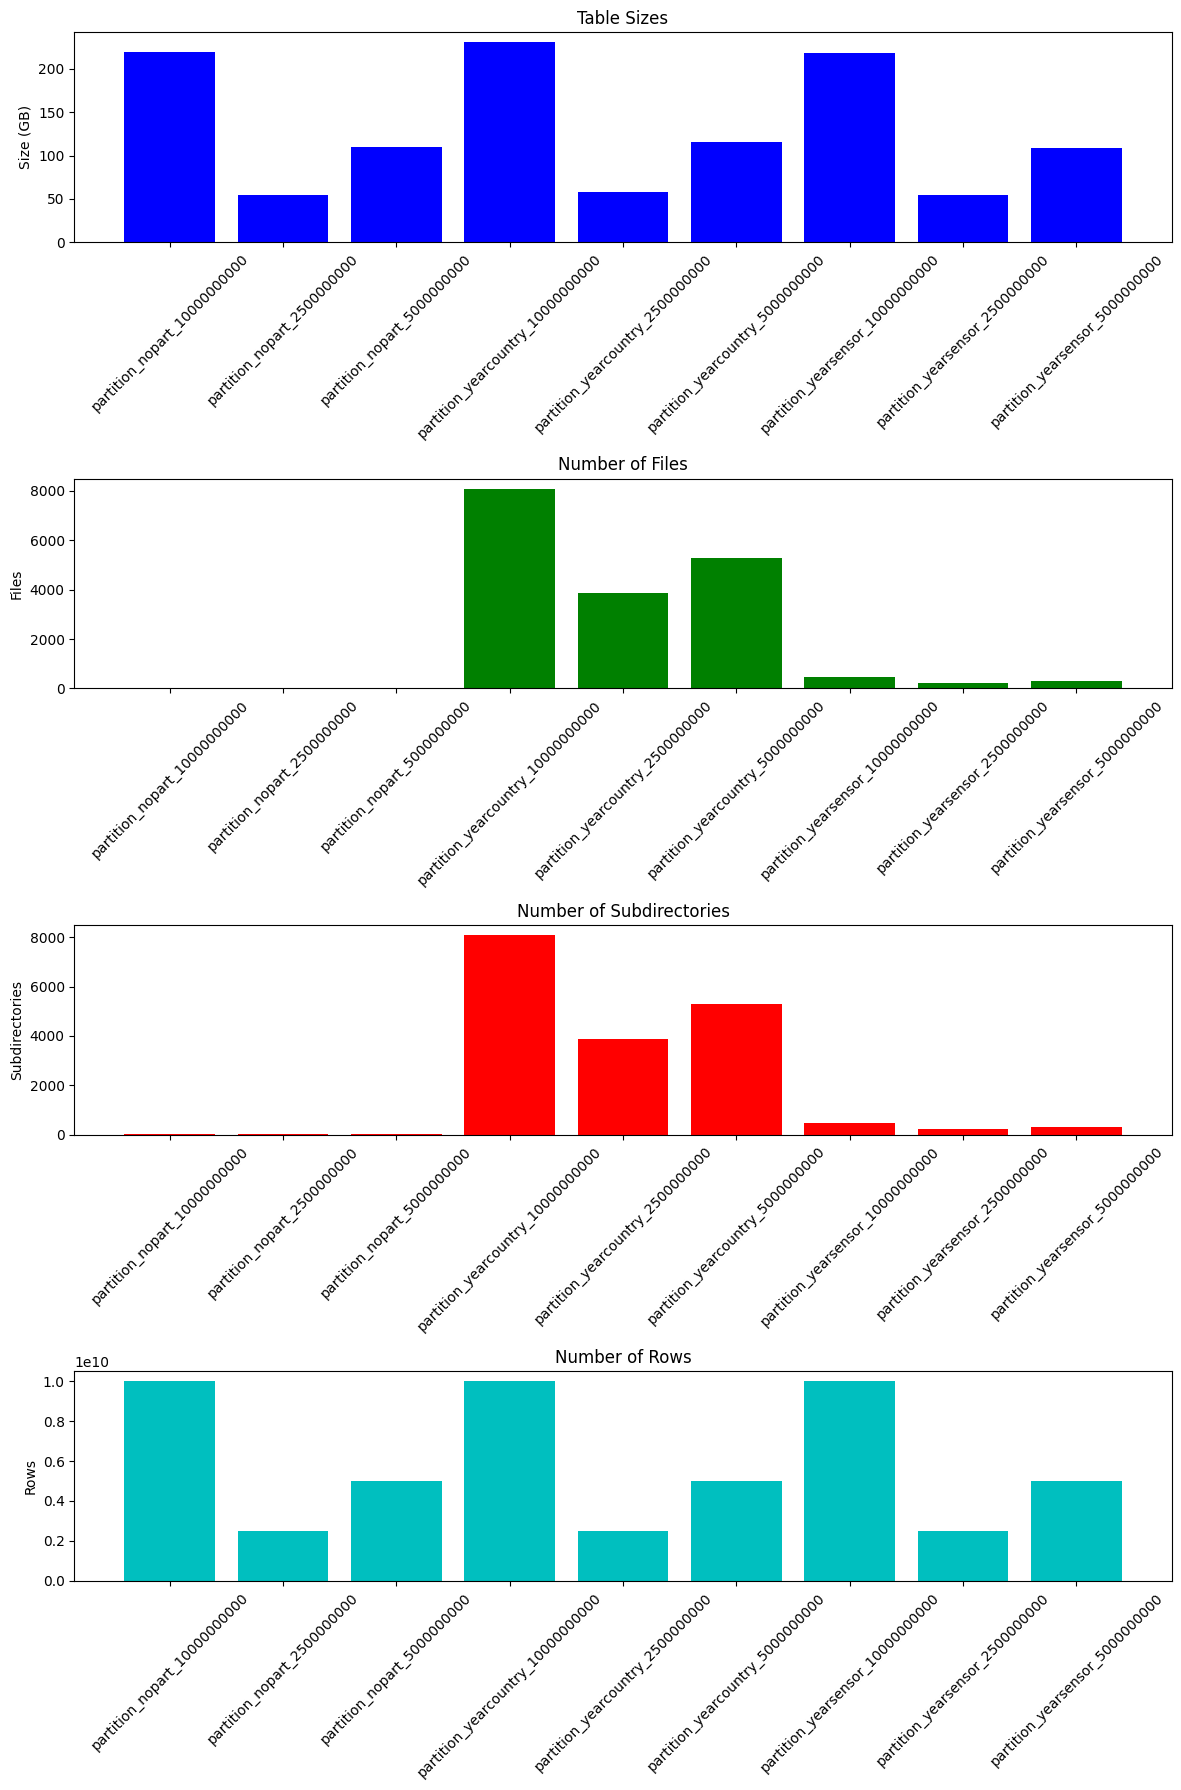

In [10]:
import subprocess
import matplotlib.pyplot as plt

spark.sql("USE partition")

tables_df = spark.sql("show tables")
tables = tables_df.collect()

table_details = []

for row in tables:
    if not row['isTemporary']:
        table_name = row['tableName']
        
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0]
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']
        
        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size = int(result.stdout.split()[0])
        
        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[1])
        
        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']
        
        table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

for table in table_details:
    print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

# Extract data for plotting
table_names = [table[0] for table in table_details]
hdfs_paths = [table[1] for table in table_details]
sizes = [table[2] / (1024 ** 3) for table in table_details]  # Convert bytes to GB for plotting
num_files = [table[3] for table in table_details]
subdirectories = [table[5] for table in table_details]
row_counts = [table[6] for table in table_details]

fig, axs = plt.subplots(4, 1, figsize=(12, 18))

axs[0].bar(table_names, sizes, color='b', align='center')
axs[0].set_title('Table Sizes')
axs[0].set_ylabel('Size (GB)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(table_names, num_files, color='g', align='center')
axs[1].set_title('Number of Files')
axs[1].set_ylabel('Files')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(table_names, subdirectories, color='r', align='center')
axs[2].set_title('Number of Subdirectories')
axs[2].set_ylabel('Subdirectories')
axs[2].tick_params(axis='x', rotation=45)

axs[3].bar(table_names, row_counts, color='c', align='center')
axs[3].set_title('Number of Rows')
axs[3].set_ylabel('Rows')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


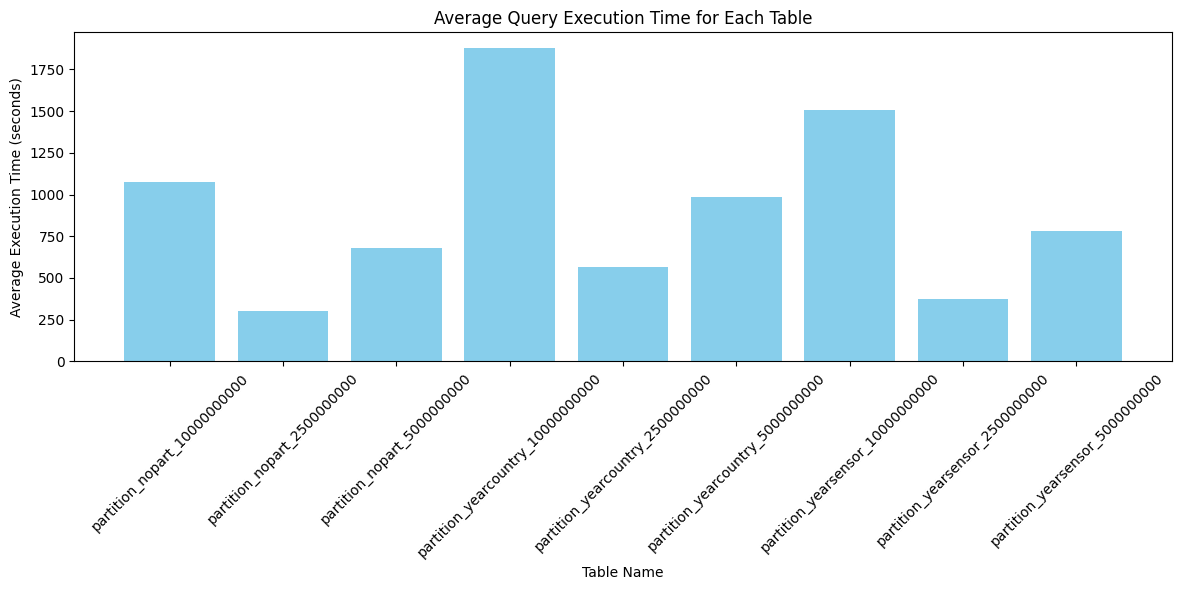

In [14]:
import time
import matplotlib.pyplot as plt
import pandas as pd

tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 2

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).collect()  # Execute the query
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"SELECT avg(value) FROM {table}"
        execution_time = measure_execution_time(query)
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603844|   63171619|
+---------+-------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603844|   63171619|
+---------+-------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603844|   63171619|
+---------+-------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660385|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660386|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734603|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734604|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734603|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734603|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734604|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513416|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513417|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513417|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513419|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513417|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660375|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660375|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660372|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660372|   63171619|
+---------+------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603705|   63171619|
+---------+-------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734618|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734618|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734619|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734621|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734618|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513414|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513415|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513415|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513415|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513414|   63159493|
+---------+------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603866|   63171619|
+---------+-------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603866|   63171619|
+---------+-------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660387|   63171619|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999858933660387|   63171619|
+---------+------------------+-----------+



+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49998589336603866|   63171619|
+---------+-------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734586|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734585|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734586|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734586|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000027020734586|   63149876|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513351|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513352|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513352|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513352|   63159493|
+---------+------------------+-----------+



+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000288374513351|   63159493|
+---------+------------------+-----------+



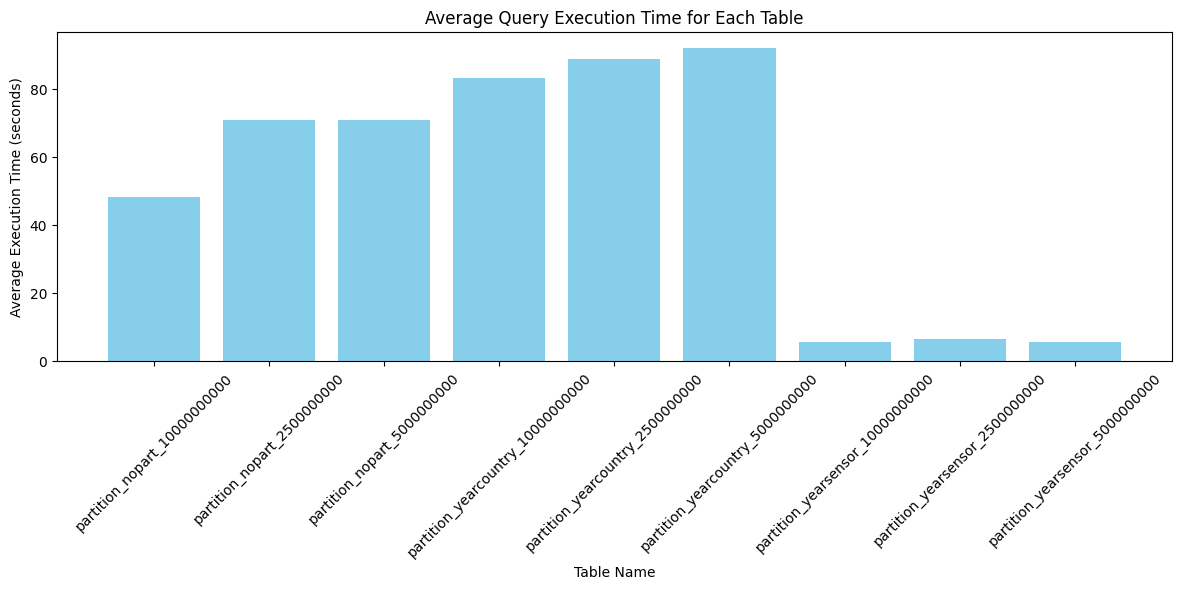

In [4]:
import time
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the list of tables
tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show()  # Execute the query
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        WITH FilteredData AS (
            SELECT
                date,
                timestamp,
                value,
                country,
                sensor_id,
                event_id,
                actor_id,
                year,
                month,
                day
            FROM
                {table}
            WHERE
                sensor_id = 'G8D1L8BF'
                AND year BETWEEN '2027' AND '2028'
        ),
        AggregatedData AS (
            SELECT
                sensor_id,
                AVG(value) AS avg_value,
                COUNT(event_id) AS event_count
            FROM
                FilteredData
            GROUP BY
                sensor_id
        )
        SELECT
            sensor_id,
            avg_value,
            event_count
        FROM
            AggregatedData
        ORDER BY
            avg_value DESC
        LIMIT 3;
        """
        execution_time = measure_execution_time(query)
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
print(df)

                               Table  Average Execution Time
0       partition_nopart_10000000000               48.361893
1        partition_nopart_2500000000               70.840493
2        partition_nopart_5000000000               70.814056
3  partition_yearcountry_10000000000               83.357689
4   partition_yearcountry_2500000000               88.977992
5   partition_yearcountry_5000000000               92.083036
6   partition_yearsensor_10000000000                5.590310
7    partition_yearsensor_2500000000                6.637540
8    partition_yearsensor_5000000000                5.728879


In [31]:
average_times_query1_before = {
    'small_table\n($1\\times10^9$ rows)': 48.361893,
    'medium_table\n($2.5\\times10^9$ rows)': 70.840493,
    'big_table\n($5\\times10^9$ rows)': 70.814056
}
average_times_query2_before = {
    'small_table\n($1\\times10^9$ rows)': 48.361893,
    'medium_table\n($2.5\\times10^9$ rows)': 70.840493,
    'big_table\n($5\\times10^9$ rows)': 70.814056
}


average_times_query1_after = {
    'small_table\n($1\\times10^9$ rows)': 83.357689,
    'medium_table\n($2.5\\times10^9$ rows)': 88.977992,
    'big_table\n($5\\times10^9$ rows)': 92.083036
}

average_times_query2_after = {
    'small_table\n($1\\times10^9$ rows)': 5.590310,
    'medium_table\n($2.5\\times10^9$ rows)': 6.637540,
    'big_table\n($5\\times10^9$ rows)': 5.728879
}


In [38]:
import pandas as pd
import matplotlib.pyplot as plt




def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Partitioning"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Partitioning"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Partitioningkey {query_num})')
    plt.xticks(rotation=0)
    
    # Set y-axis limit to 500
    plt.ylim(0, 110)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12})  # Fine-tune the position

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  # Center and slightly above the bar
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'part_table_performance_{query_num}.png', dpi=500)
    plt.show()

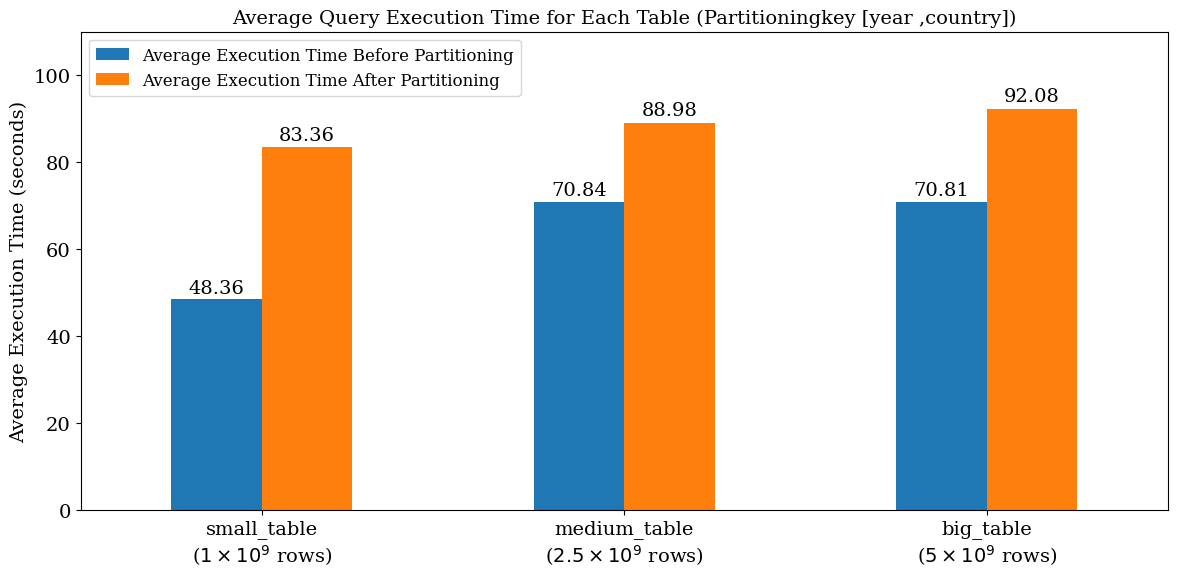

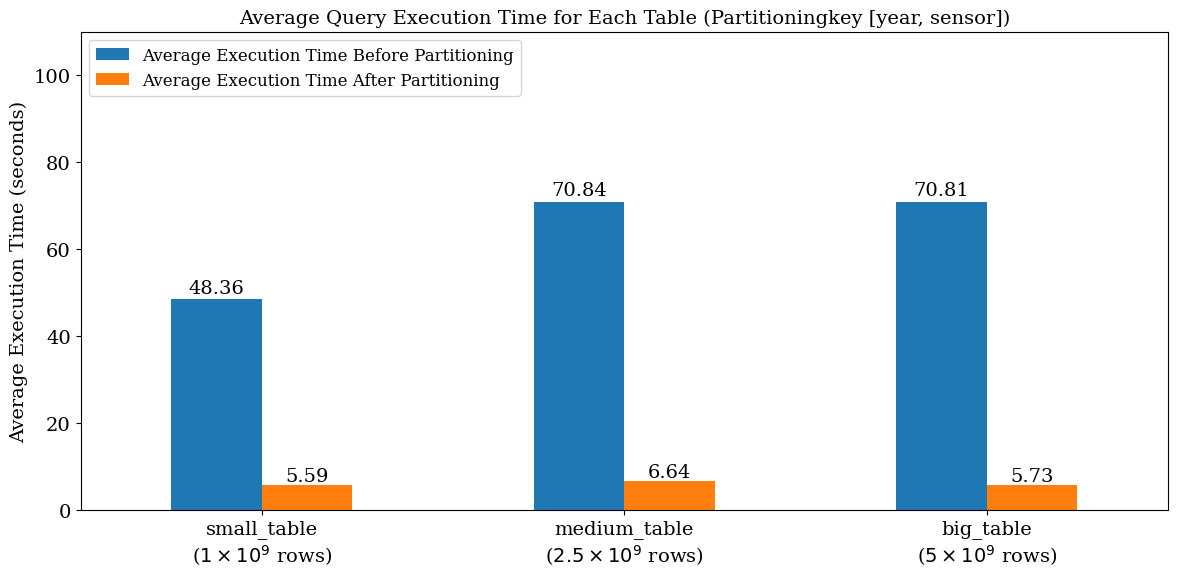

In [39]:
plot_comparison(average_times_query1_before, average_times_query1_after, "[year ,country]")
plot_comparison(average_times_query2_before, average_times_query2_after, "[year, sensor]")

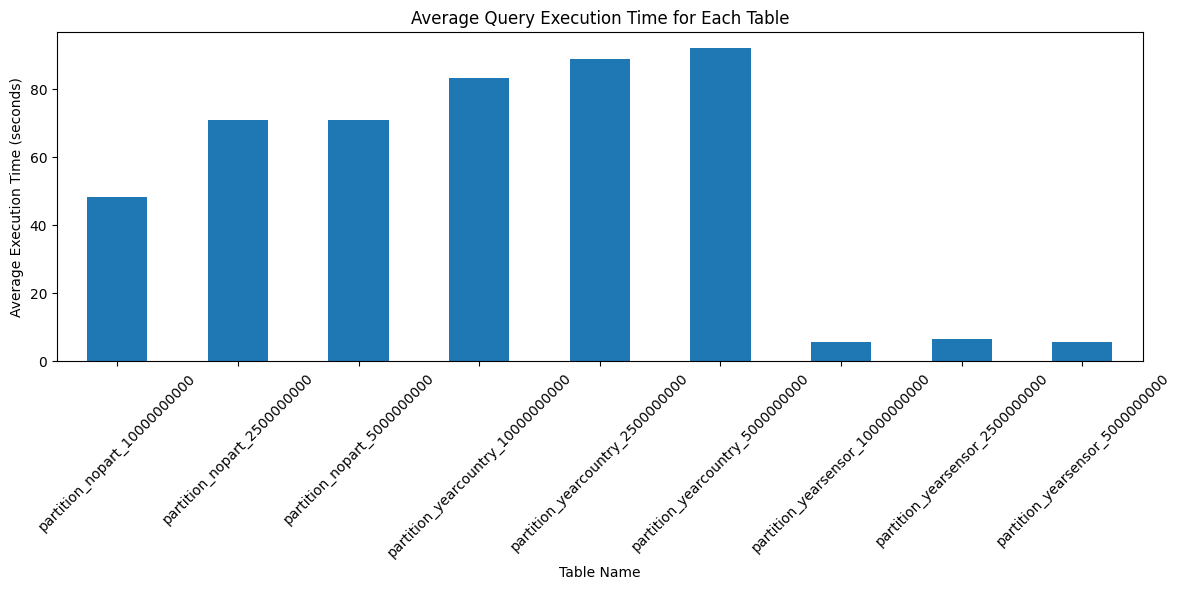

In [6]:
plot_execution_times(average_execution_times)

In [17]:
from delta.tables import DeltaTable

tables_df = spark.sql("SHOW TABLES")
table_names = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]

base_path = "hdfs://192.168.0.144:9000/datalake/partition/"

def optimize_table(table_name):
    table_path = f"{base_path}{table_name}"
    delta_table = DeltaTable.forPath(spark, table_path)
    delta_table.optimize().executeCompaction()
    print(f"Optimized table: {table_name}")

for table_name in table_names:
    optimize_table(table_name)

Optimized table: partition_monthcountry_table_1000000000


Optimized table: partition_monthcountry_table_2000000000


Optimized table: partition_monthcountry_table_4000000000


Optimized table: partition_monthcountry_table_500000000
Optimized table: partition_nopart_table_1000000000
Optimized table: partition_nopart_table_2000000000
Optimized table: partition_nopart_table_4000000000
Optimized table: partition_nopart_table_500000000


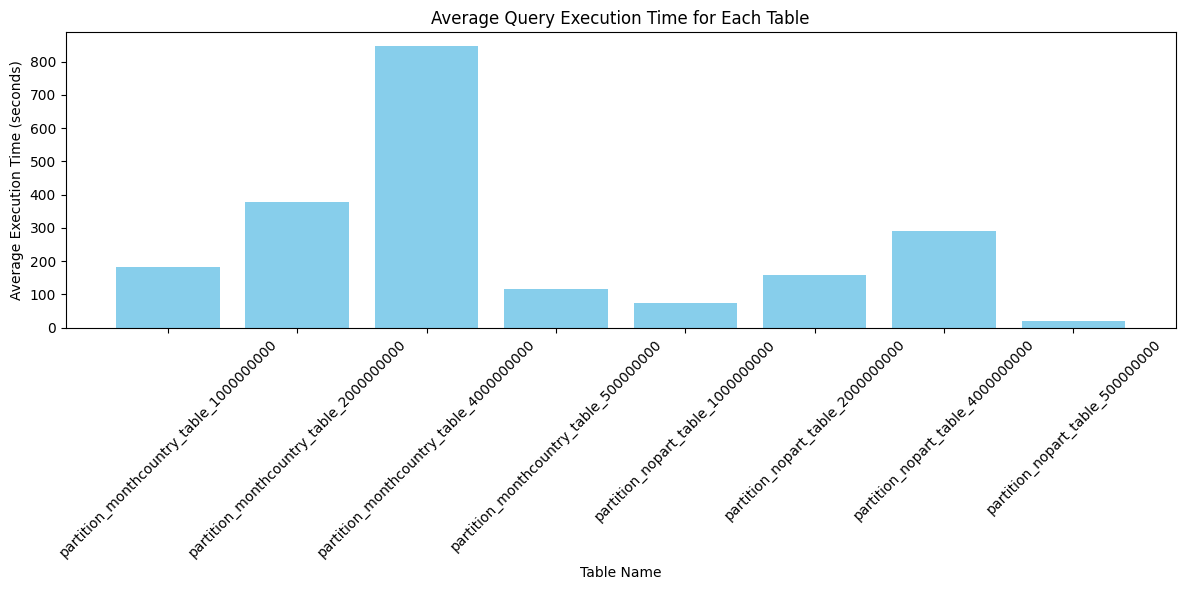

In [18]:
import time
import matplotlib.pyplot as plt
import pandas as pd

tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 2

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).collect()  # Execute the query
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"SELECT avg(value) FROM {table}"
        execution_time = measure_execution_time(query)
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                               Table  Average Execution Time
0       partition_nopart_10000000000                5.813205
1        partition_nopart_2500000000                0.835139
2        partition_nopart_5000000000                4.605914
3  partition_yearcountry_10000000000                1.136866
4   partition_yearcountry_2500000000                0.812788
5   partition_yearcountry_5000000000                1.003613
6   partition_yearsensor_10000000000               11.090216
7    partition_yearsensor_2500000000                0.740625
8    partition_yearsensor_5000000000                8.575154


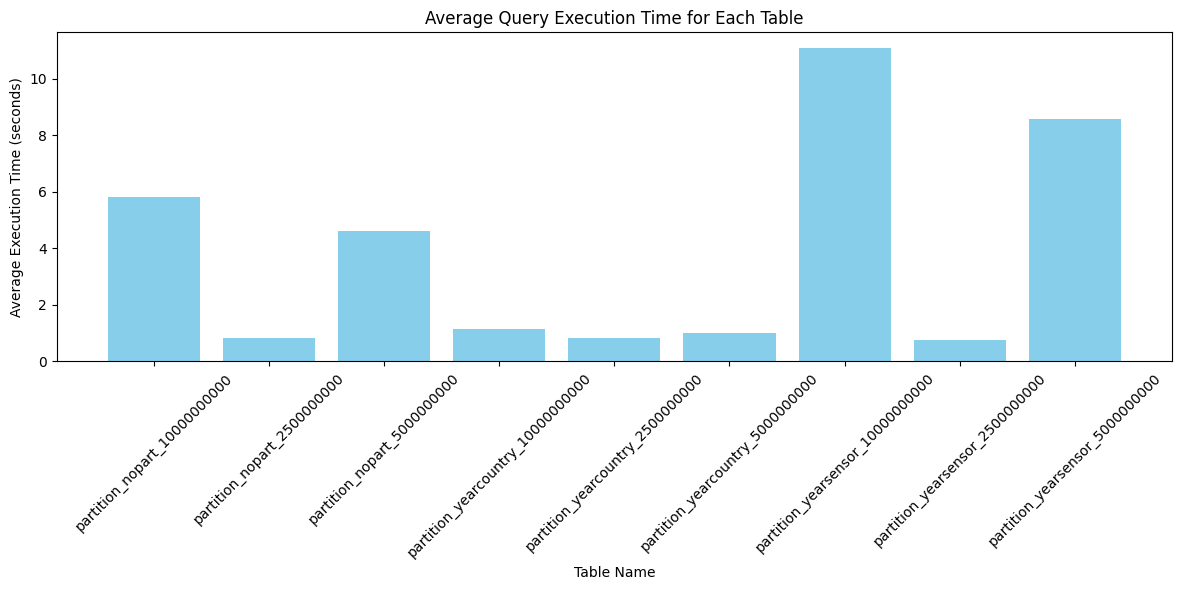

In [15]:
import time
import matplotlib.pyplot as plt
import pandas as pd

tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).collect()  # Execute the query
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"SELECT avg(value) FROM {table} WHERE month=203502 and country='Germany'"
        execution_time = measure_execution_time(query)
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [64]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType



def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

def get_average_execution_times(query_template, num_executions, tables):
    execution_times = {table: [] for table in tables}
    for table in tables:
        for _ in range(num_executions):
            query = query_template.format(table=table)
            try:
                execution_time = measure_execution_time(query)
                print(f"{table}: {execution_time} seconds")
                execution_times[table].append(execution_time)
            except Exception as e:
                print(f"Error for table {table}: {e}")
    average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
    return average_times

query1_template = """
        WITH FilteredData AS (
            SELECT
                date,
                timestamp,
                value,
                country,
                sensor_id,
                event_id,
                actor_id,
                year,
                month,
                day
            FROM
                {table}
            WHERE
                sensor_id = 'G8D1L8BF'
                AND year BETWEEN '2027' AND '2028'
        ),
        AggregatedData AS (
            SELECT
                sensor_id,
                AVG(value) AS avg_value,
                COUNT(event_id) AS event_count
            FROM
                FilteredData
            GROUP BY
                sensor_id
        )
        SELECT
            sensor_id,
            avg_value,
            event_count
        FROM
            AggregatedData
        ORDER BY
            avg_value DESC
        LIMIT 3;
        """

query2_template = """
SELECT avg(value) FROM {table} WHERE month=203502 and country='Germany'
"""

+----------+---------------------+-------------------+--------------+---------+----------+----------+----+------+--------+
|date      |timestamp            |value              |country       |sensor_id|event_id  |actor_id  |year|month |day     |
+----------+---------------------+-------------------+--------------+---------+----------+----------+----+------+--------+
|2024-01-01|2029-01-17 00:01:14.1|0.43081312113027004|Bahrain       |AE5SXNCD |1592352742|1592353742|2029|202901|20290117|
|2024-01-01|2029-12-07 22:30:51.2|0.10637303381442242|Congo         |AE5SXNCD |1873098513|1873099513|2029|202912|20291207|
|2024-01-01|2029-01-04 01:19:54  |0.5586779570684214 |Cameroon      |AE5SXNCD |1581167941|1581168941|2029|202901|20290104|
|2024-01-01|2029-04-18 21:49:48.1|0.8057469414849394 |Moldova       |AE5SXNCD |1671761882|1671762882|2029|202904|20290418|
|2024-01-01|2029-01-17 00:01:15.1|0.6201638338548641 |Kuwait        |AE5SXNCD |1592352752|1592353752|2029|202901|20290117|
|2024-01-01|2029

In [78]:
num_executions = 10
tables = [
    "partition_yearsensor_8",
    "partition_yearcountry_8",
    "partition_nopart_8",
    "partition_yearsensor_4",
    "partition_yearcountry_4",
    "partition_nopart_4",
    "partition_yearsensor_2",
    "partition_yearcountry_2",
    "partition_nopart_2"
]

average_times_query1_before = get_average_execution_times(query1_template, num_executions, tables)
average_times_query2_before = get_average_execution_times(query2_template, num_executions, tables)

+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145944|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 5.021226644515991 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.8546264171600342 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.9300949573516846 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 4.3585145473480225 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145944|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.7389593124389648 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 2.612354278564453 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.6535208225250244 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145944|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 2.473400592803955 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145945|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.735849380493164 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145944|   63153134|
+---------+------------------+-----------+

partition_yearsensor_8: 1.7958431243896484 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145835|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 56.920013189315796 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145835|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 41.72804117202759 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145834|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 24.313509702682495 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145837|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 15.129229068756104 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145834|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 13.97117805480957 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145834|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 14.304523944854736 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145836|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 13.826218605041504 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145835|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 13.13045620918274 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145835|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 12.41971230506897 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145834|   63153134|
+---------+------------------+-----------+

partition_yearcountry_8: 12.41545033454895 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 49.49371027946472 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 51.024763107299805 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 12.726358413696289 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 12.719046831130981 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 21.352375268936157 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 15.43617057800293 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.500047522414583|   63153134|
+---------+-----------------+-----------+

partition_nopart_8: 12.520065069198608 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145827|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 12.528485536575317 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 12.29149580001831 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.5000475224145828|   63153134|
+---------+------------------+-----------+

partition_nopart_8: 12.134894847869873 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 4.7288243770599365 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.6650798320770264 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.6041226387023926 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.8657546043395996 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.924546241760254 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 2.950146198272705 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 4.2124409675598145 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.6911096572875977 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 1.6859889030456543 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365804|   63160797|
+---------+------------------+-----------+

partition_yearsensor_4: 2.9425530433654785 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659234|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 52.61559057235718 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659234|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 53.91686725616455 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659217|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 13.960839033126831 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659245|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 12.80697751045227 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365922|   63160797|
+---------+------------------+-----------+

partition_yearcountry_4: 12.66025185585022 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659217|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 12.543893575668335 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659206|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 13.463701963424683 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659217|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 12.816253185272217 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997801436592|   63160797|
+---------+-----------------+-----------+

partition_yearcountry_4: 13.399345874786377 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659234|   63160797|
+---------+-------------------+-----------+

partition_yearcountry_4: 12.59270715713501 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365935|   63160797|
+---------+------------------+-----------+

partition_nopart_4: 50.12255501747131 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 52.73348569869995 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 13.299619674682617 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365935|   63160797|
+---------+------------------+-----------+

partition_nopart_4: 12.41899037361145 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 11.867844343185425 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 12.94800066947937 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 16.928236961364746 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659345|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 15.302714109420776 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999978014365934|   63160797|
+---------+------------------+-----------+

partition_nopart_4: 17.281870126724243 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999780143659317|   63160797|
+---------+-------------------+-----------+

partition_nopart_4: 15.890470504760742 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400718|   63158373|
+---------+-----------------+-----------+

partition_yearsensor_2: 5.154731273651123 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007179|   63158373|
+---------+------------------+-----------+

partition_yearsensor_2: 1.7303216457366943 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400718|   63158373|
+---------+-----------------+-----------+

partition_yearsensor_2: 1.6465179920196533 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007179|   63158373|
+---------+------------------+-----------+

partition_yearsensor_2: 1.6144213676452637 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007179|   63158373|
+---------+------------------+-----------+

partition_yearsensor_2: 3.8217899799346924 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400718|   63158373|
+---------+-----------------+-----------+

partition_yearsensor_2: 1.6173601150512695 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400718|   63158373|
+---------+-----------------+-----------+

partition_yearsensor_2: 1.7364780902862549 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400718|   63158373|
+---------+-----------------+-----------+

partition_yearsensor_2: 4.775918006896973 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007179|   63158373|
+---------+------------------+-----------+

partition_yearsensor_2: 1.7418456077575684 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007179|   63158373|
+---------+------------------+-----------+

partition_yearsensor_2: 1.6820964813232422 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071604|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 55.394710540771484 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071587|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 57.30586552619934 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071626|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 13.849095106124878 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007161|   63158373|
+---------+------------------+-----------+

partition_yearcountry_2: 12.784606218338013 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400716|   63158373|
+---------+-----------------+-----------+

partition_yearcountry_2: 12.7561776638031 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007158|   63158373|
+---------+------------------+-----------+

partition_yearcountry_2: 12.928266286849976 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071615|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 12.651622533798218 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071615|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 12.800312757492065 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071626|   63158373|
+---------+-------------------+-----------+

partition_yearcountry_2: 15.457492589950562 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007161|   63158373|
+---------+------------------+-----------+

partition_yearcountry_2: 14.503912925720215 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007159|   63158373|
+---------+------------------+-----------+

partition_nopart_2: 47.47417116165161 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007162|   63158373|
+---------+------------------+-----------+

partition_nopart_2: 51.270503520965576 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071604|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 13.100363731384277 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071604|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 14.102365493774414 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071615|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 14.280715465545654 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071587|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 12.254870891571045 seconds


+---------+------------------+-----------+
|sensor_id|         avg_value|event_count|
+---------+------------------+-----------+
| G8D1L8BF|0.4999971164007161|   63158373|
+---------+------------------+-----------+

partition_nopart_2: 12.109642267227173 seconds


+---------+-----------------+-----------+
|sensor_id|        avg_value|event_count|
+---------+-----------------+-----------+
| G8D1L8BF|0.499997116400716|   63158373|
+---------+-----------------+-----------+

partition_nopart_2: 12.2713782787323 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071587|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 11.90029764175415 seconds


+---------+-------------------+-----------+
|sensor_id|          avg_value|event_count|
+---------+-------------------+-----------+
| G8D1L8BF|0.49999711640071604|   63158373|
+---------+-------------------+-----------+

partition_nopart_2: 13.677657127380371 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318594|
+-------------------+

partition_yearsensor_8: 8.386645078659058 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318594|
+-------------------+

partition_yearsensor_8: 2.539022922515869 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318605|
+-------------------+

partition_yearsensor_8: 2.5043492317199707 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331858|
+------------------+

partition_yearsensor_8: 2.351473331451416 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318594|
+-------------------+

partition_yearsensor_8: 2.570866823196411 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331858|
+------------------+

partition_yearsensor_8: 4.929239988327026 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331858|
+------------------+

partition_yearsensor_8: 3.8486499786376953 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318594|
+-------------------+

partition_yearsensor_8: 3.246149778366089 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318605|
+-------------------+

partition_yearsensor_8: 3.22351336479187 seconds


+-------------------+
|         avg(value)|
+-------------------+
|0.49995521473318594|
+-------------------+

partition_yearsensor_8: 2.4809420108795166 seconds
+------------------+
|        avg(value)|
+------------------+
|0.4999552147331794|
+------------------+

partition_yearcountry_8: 0.5699441432952881 seconds
+------------------+
|        avg(value)|
+------------------+
|0.4999552147331794|
+------------------+

partition_yearcountry_8: 0.39522361755371094 seconds
+------------------+
|        avg(value)|
+------------------+
|0.4999552147331794|
+------------------+

partition_yearcountry_8: 0.7019798755645752 seconds
+------------------+
|        avg(value)|
+------------------+
|0.4999552147331794|
+------------------+

partition_yearcountry_8: 0.3990800380706787 seconds
+------------------+
|        avg(value)|
+------------------+
|0.4999552147331794|
+------------------+

partition_yearcountry_8: 0.358731746673584 seconds
+------------------+
|        avg(value)|
+-----

+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 2.4639251232147217 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.2505993843078613 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331843|
+------------------+

partition_nopart_8: 1.2007348537445068 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331843|
+------------------+

partition_nopart_8: 1.4118103981018066 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.3472304344177246 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.464869499206543 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.4745984077453613 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.8005876541137695 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.3034813404083252 seconds


+------------------+
|        avg(value)|
+------------------+
|0.4999552147331842|
+------------------+

partition_nopart_8: 1.4523954391479492 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 9.540299415588379 seconds


+------------------+
|        avg(value)|
+------------------+
|0.5008309669418629|
+------------------+

partition_yearsensor_4: 2.61395525932312 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 2.8243072032928467 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 2.5646185874938965 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 2.403841495513916 seconds


+------------------+
|        avg(value)|
+------------------+
|0.5008309669418629|
+------------------+

partition_yearsensor_4: 2.51452898979187 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 2.616727113723755 seconds


+------------------+
|        avg(value)|
+------------------+
|0.5008309669418629|
+------------------+

partition_yearsensor_4: 2.5725436210632324 seconds


+-----------------+
|       avg(value)|
+-----------------+
|0.500830966941863|
+-----------------+

partition_yearsensor_4: 2.603562116622925 seconds


+------------------+
|        avg(value)|
+------------------+
|0.5008309669418628|
+------------------+

partition_yearsensor_4: 2.4595799446105957 seconds
+------------------+
|        avg(value)|
+------------------+
|0.5008309669418655|
+------------------+

partition_yearcountry_4: 0.41061973571777344 seconds
+------------------+
|        avg(value)|
+------------------+
|0.5008309669418655|
+------------------+

partition_yearcountry_4: 0.31618595123291016 seconds
+------------------+
|        avg(value)|
+------------------+
|0.5008309669418655|
+------------------+

partition_yearcountry_4: 0.5689961910247803 seconds
+------------------+
|        avg(value)|
+------------------+
|0.5008309669418655|
+------------------+

partition_yearcountry_4: 0.3452625274658203 seconds
+------------------+
|        avg(value)|
+------------------+
|0.5008309669418655|
+------------------+

partition_yearcountry_4: 0.447833776473999 seconds
+------------------+
|        avg(value)|
+---------

+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.8419859409332275 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0176019668579102 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0435547828674316 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0062363147735596 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0276505947113037 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.099862813949585 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0562071800231934 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0149171352386475 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0405824184417725 seconds


+----------------+
|      avg(value)|
+----------------+
|0.50083096694186|
+----------------+

partition_nopart_4: 1.0949492454528809 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.24314212799072266 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.20650982856750488 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.2130870819091797 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.22459650039672852 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.21594452857971191 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.2427215576171875 seconds
+----------+
|avg(value)|
+----------+
|      NULL|
+----------+

partition_yearsensor_2: 0.22314739227294922 seconds
+----------+
|avg(value)|
+------

In [89]:
print(average_times_query1_before)
print(average_times_query2_before)

{'partition_yearsensor_8': 2.5174390077590942, 'partition_yearcountry_8': 21.815833258628846, 'partition_nopart_8': 21.2227365732193, 'partition_yearsensor_4': 2.527056646347046, 'partition_yearcountry_4': 21.077642798423767, 'partition_nopart_4': 21.879378747940063, 'partition_yearsensor_2': 2.5521480560302736, 'partition_yearcountry_2': 22.043206214904785, 'partition_nopart_2': 20.244196557998656}
{'partition_yearcountry_2': 83.357689, 'partition_yearcountry_4': 88.977992, 'partition_yearcountry_8': 92.083036}


In [ ]:
average_times_query1_before = {
    'partition_nopart_8': 48.48555517196655,
    'partition_partition_nopart_4': 45.33076333999634,
    'partition_nopart_2': 44.599549293518066
}
average_times_query2_before = {
    'partition_yearsensor_8': 4.197077035903931,
    'partition_yearsensor_4':  4.379481077194214,
    'partition_yearsensor_2': 4.754835367202759
}


average_times_query2_after = {
    'partition_yearcountry_2': 83.357689,
    'partition_yearcountry_4': 88.977992,
    'partition_yearcountry_8': 92.083036
}

average_times_query2_before = {
    'partition_nopart_2': 5.590310,
    'partition_nopart_4': 6.637540,
    'partition_nopart_8': 5.728879
}
 'partition_yearcountry_8': 0.48323941230773926,
 'partition_nopart_8': 2.1306607723236084,
 'partition_yearcountry_4': 0.4241940975189209,
 'partition_nopart_4': 2.559170722961426,
 'partition_yearcountry_2': 0.24526143074035645,
 'partition_nopart_2': 0.1879255771636963}

In [67]:
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_table_details(spark, tables):
    os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
    os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

    table_details = []

    for table_name in tables:
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0].asDict()
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']
        
        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size_bytes = int(result.stdout.split()[0])
        size_gb = size_bytes / (1024 ** 3)  
        
        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[0]) - 1  
        
        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']
        
        table_details.append((table_name, hdfs_location, size_gb, num_files, partition_columns, subdirectories, row_count))

    for table in table_details:
        print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]:.2f} GB, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

    table_names = [table[0] for table in table_details]
    sizes = [table[2] for table in table_details]  
    num_files = [table[3] for table in table_details]
    subdirectories = [table[5] for table in table_details]
    row_counts = [table[6] for table in table_details]

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['DejaVu Serif']
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(4, 1, figsize=(10, 12))

    font_size = 14

    def add_values_to_bars(ax, rects, fmt='{:.2f}'):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(fmt.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -18), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=font_size, color='black',
                        fontfamily='serif', fontname='DejaVu Serif')

    for ax in axs:
        ax.set_axisbelow(True)
        ax.grid(True, which='both', linewidth=1) 

    rects0 = axs[0].bar(table_names, sizes, color=sns.color_palette("muted"))
    axs[0].set_title('Table Sizes', fontsize=font_size)
    axs[0].set_ylabel('Size (GB)', fontsize=font_size)
    axs[0].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[0], rects0)

    rects1 = axs[1].bar(table_names, num_files, color=sns.color_palette("muted"))
    axs[1].set_title('Number of Files', fontsize=font_size)
    axs[1].set_ylabel('Files', fontsize=font_size)
    axs[1].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[1], rects1, fmt='{:.0f}')

    rects2 = axs[2].bar(table_names, subdirectories, color=sns.color_palette("muted"))
    axs[2].set_title('Number of Subdirectories (only relevant for partitioning)', fontsize=font_size)
    axs[2].set_ylabel('Subdirectories', fontsize=font_size)
    axs[2].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[2], rects2, fmt='{:.0f}')

    rects3 = axs[3].bar(table_names, row_counts, color=sns.color_palette("muted"))
    axs[3].set_title('Number of Rows', fontsize=font_size)
    axs[3].set_ylabel('Rows', fontsize=font_size)
    axs[3].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[3], rects3, fmt='{:.0f}')

    plt.tight_layout()
    plt.savefig('compaction_table_details.png', dpi=400)
    plt.show()

# Example usage
# tables = ["table1", "table2", "table3"]
# analyze_table_details(spark, tables)


Table: partition_yearsensor_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_8, Size: 174.65 GB, Number of Files: 260, Partition Columns: ['year', 'sensor_id'], Subdirectories: 288, Number of Rows: 8000000000
Table: partition_yearcountry_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_yearcountry_8, Size: 184.40 GB, Number of Files: 4576, Partition Columns: ['year', 'country'], Subdirectories: 4604, Number of Rows: 8000000000
Table: partition_nopart_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_nopart_8, Size: 175.87 GB, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000
Table: partition_yearsensor_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/partition/partition_yearsensor_4, Size: 87.33 GB, Number of Files: 130, Partition Columns: ['year', 'sensor_id'], Subdirectories: 145, Number of Rows: 4000000000
Table: partition_yearcountry_4, HDFS Directory: h

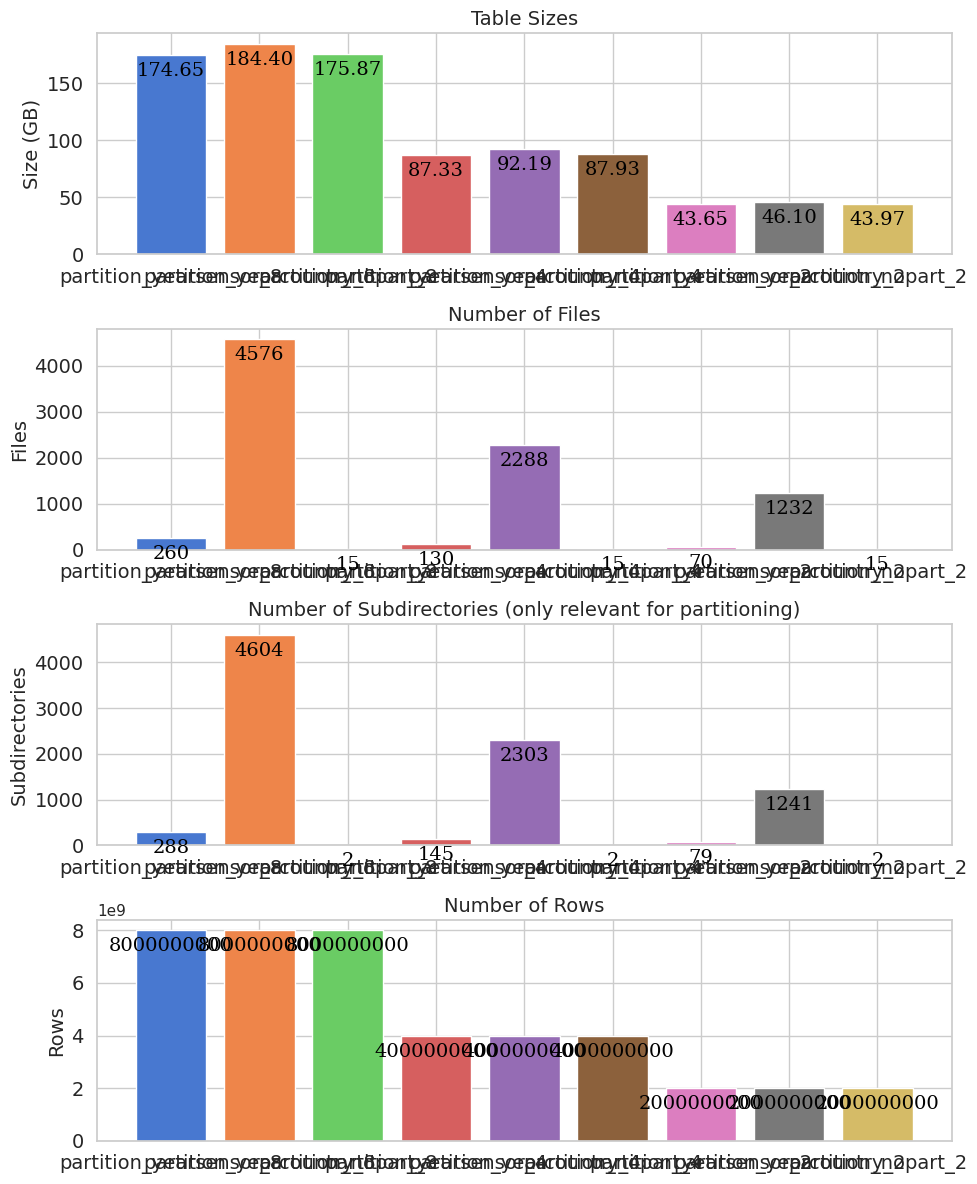

In [68]:
analyze_table_details(spark, tables)

In [75]:
average_times_query1_before = {
    'partition_yearsensor_8': 48.48555517196655,
    'partition_yearsensor_4': 45.33076333999634,
    'partition_yearsensor_2': 44.599549293518066
}
average_times_query1_after = {
    'partition_yearsensor_8': 4.197077035903931,
    'partition_yearsensor_4':  4.379481077194214,
    'partition_yearsensor_2': 4.754835367202759
}



In [76]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_comparison(before_times, after_times, query_num):
    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After"])
    df = df_before.merge(df_after, on="Table")

    df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.xlabel('Table Name')
    plt.ylabel('Average Execution Time (seconds)')
    plt.title(f'Average Query Execution Time for Each Table (Partitionkey {query_num})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'part_table_performance_{query_num}.png', dpi=400)
    plt.show()

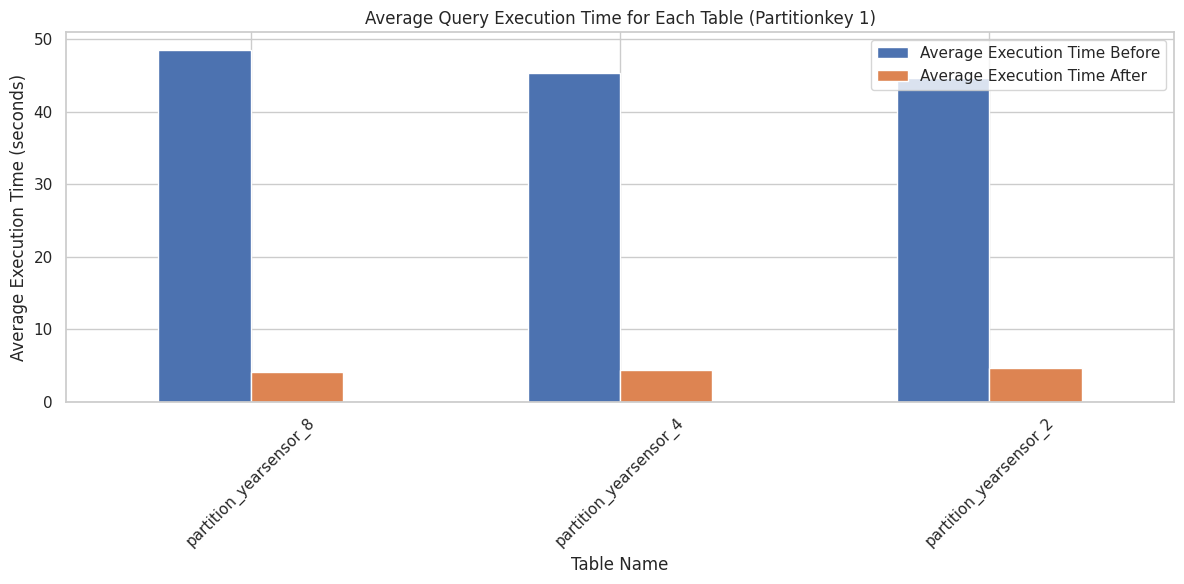

In [77]:
plot_comparison(average_times_query1_before, average_times_query1_after, 1)


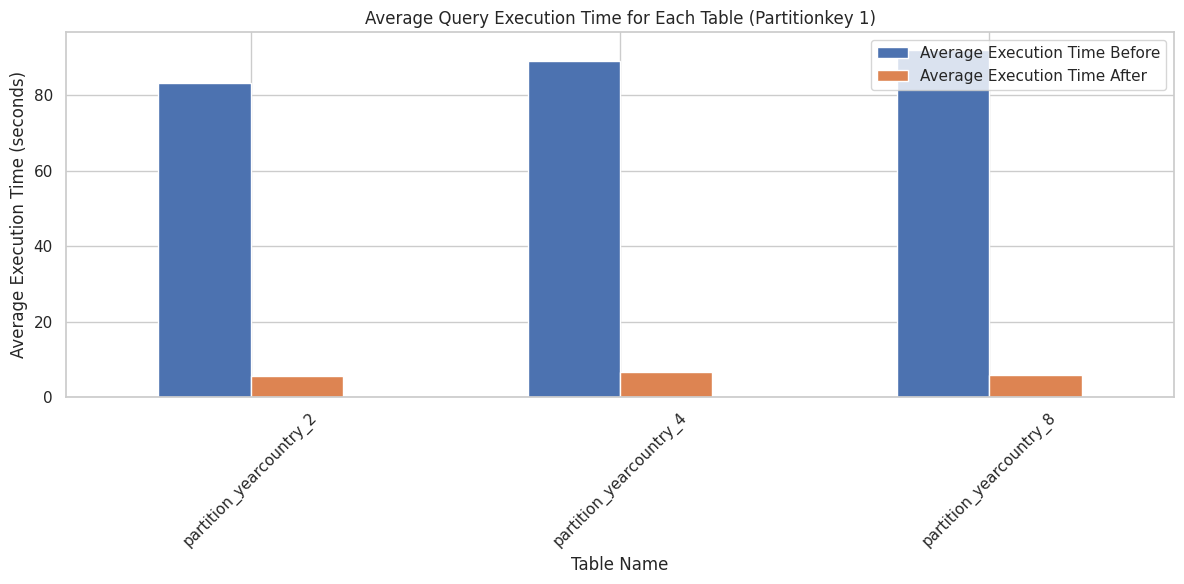

In [88]:
average_times_query2_before = {
    'partition_yearcountry_2': 83.357689,
    'partition_yearcountry_4': 88.977992,
    'partition_yearcountry_8': 92.083036
}

average_times_query2_after = {
    'partition_yearcountry_2': 5.590310,
    'partition_yearcountry_4': 6.637540,
    'partition_yearcountry_8': 5.728879
}
plot_comparison(average_times_query2_before, average_times_query2_after, 1)
